# Discovery of Writing Differences - Neural Networks Representation

Capstone project by Tomo Umer

<img src="https://tomoumerdotcom.files.wordpress.com/2022/04/cropped-pho_logo_notext.png" style="width:400px;height:400px;"/>

## Imports

In [1]:
import pandas as pd
import numpy as np
import re
import glob
import plotly.express as px
import pickle

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.preprocessing import MaxAbsScaler
from copy import deepcopy

import umap
from scipy import spatial
from scipy.cluster.hierarchy import linkage, dendrogram

from joblib import dump, load

/Users/tomoumer/opt/anaconda3/envs/huggingface_ds6/lib/python3.11/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/tomoumer/opt/anaconda3/envs/huggingface_ds6/lib/python3.11/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/tomoumer/opt/anaconda3/envs/hug

## Reading In the Library and Prep for NN

In this part, reading the .pkl file. 

In [2]:
library_select = pd.read_pickle('../data/library_fixed_author_fifty.pkl')

In [3]:
library_select.shape

(527, 14)

just grab the select authors names since they're in the correct order (sorted it in data_exploration)

In [4]:
select_authors = list(library_select['author'].unique())

In [32]:
authors_df

,author,authorcentury,authorcentury_str,author_num
56951,Homer,-7.0,7th century BCE,0
25850,Confucius,-6.0,6th century BCE,1
5523,Plato,-4.0,4th century BCE,2
5532,"Cicero, Marcus Tullius",-1.0,1st century BCE,3
51139,"Seneca, Lucius Annaeus",1.0,1st century CE,4
69143,Dante Alighieri,13.0,13th century CE,5
15183,"Boccaccio, Giovanni",14.0,14th century CE,6
2582,"Machiavelli, Niccolò",15.0,15th century CE,7
5702,"Shakespeare, William",16.0,16th century CE,8
69442,Molière,17.0,17th century CE,9


In [37]:
authors_df.loc[authors_df['author_num'] == 5, 'author'].iloc[0]

'Dante Alighieri'

## Sklearn NN

First round of neural network analysis, using sklearn.

In [5]:
X = library_select[['book_content']]
y = library_select['author_num']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42, stratify = y)

In [6]:
pipe_nn = Pipeline(
    steps = [
        ('vect', TfidfVectorizer(min_df=1, max_df=0.5, ngram_range=(1,1))),
        ('scaler', MaxAbsScaler()),  #this is needed in order to make it converge in a reasonable time!
        ('nn', MLPClassifier(verbose = True,
                             hidden_layer_sizes = (100, 100),
                             #activation = 'relu',
                             #max_iter = 10000,
                             #alpha=0.05
                             ))
    ]
)

In [7]:
# pipe_nn.fit(X_train['book_content'], y_train)
# y_pred = pipe_nn.predict(X_test['book_content'])

# print('accuracy score:', accuracy_score(y_test, y_pred), '\n')
# print('----- confusion matrix ------')
# print(confusion_matrix(y_test, y_pred), '\n')
# print('-------- classification report ---------')
# print(classification_report(y_test, y_pred))

# this below ran for almost 2 hours and didn't finish yet...
pipe_nn.fit(X['book_content'], y)
y_pred = pipe_nn.predict(X['book_content'])

print('accuracy score:', accuracy_score(y, y_pred), '\n')
print('----- confusion matrix ------')
print(confusion_matrix(y, y_pred), '\n')
print('-------- classification report ---------')
print(classification_report(y, y_pred))

Iteration 1, loss = 2.70894711
Iteration 2, loss = 1.03147766
Iteration 3, loss = 0.30825719
Iteration 4, loss = 0.12002107
Iteration 5, loss = 0.05243777
Iteration 6, loss = 0.02298339
Iteration 7, loss = 0.00954551
Iteration 8, loss = 0.00510859
Iteration 9, loss = 0.00271510
Iteration 10, loss = 0.00179337
Iteration 11, loss = 0.00125984
Iteration 12, loss = 0.00101091
Iteration 13, loss = 0.00086809
Iteration 14, loss = 0.00075284
Iteration 15, loss = 0.00067808
Iteration 16, loss = 0.00062919
Iteration 17, loss = 0.00059884
Iteration 18, loss = 0.00056994
Iteration 19, loss = 0.00054969
Iteration 20, loss = 0.00053279
Iteration 21, loss = 0.00051899
Iteration 22, loss = 0.00050779
Iteration 23, loss = 0.00049909
Iteration 24, loss = 0.00049017
Iteration 25, loss = 0.00048273
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
accuracy score: 1.0 

----- confusion matrix ------
[[14  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 

In [8]:
#fig = px.imshow(confusion_matrix(y_test, pipe_nn.predict(X_test['book_content'])),
fig = px.imshow(confusion_matrix(y, pipe_nn.predict(X['book_content'])),
                width=1000,
                height=800,
                text_auto=True,
                labels=dict(x='Predicted Label',
                            y='True Label'),
                            x=select_authors,
                            y=select_authors,
                            color_continuous_scale='Teal'
                            )

fig.update(layout_coloraxis_showscale=False)

fig.show()

In [9]:
#pipe_nn['vect'].vocabulary_['seneca']

## Encoding and lower-dimensional representation of the NN

With a trained model, using embeddings to find similarities between books and authors.

In [10]:
# have to use the regressor because classifiers thinks we're expecting int results, even if we chop it off before final step!
# :2 and layers = 3 if I use two hidden layers with nn; for one, reduce those by 1
encoder = MLPRegressor()
encoder.coefs_ = pipe_nn['nn'].coefs_[:2]
encoder.intercepts_ = pipe_nn['nn'].intercepts_[:2]
encoder.n_layers_ = 3
encoder.out_activation_ = 'relu'

In [11]:
# copy the pipeline
pipe_nn_encoder = deepcopy(pipe_nn)

# remove the classifier
pipe_nn_encoder.steps.pop(2)

# append the new encoder (essentially, it contains all layers minus the final one)
pipe_nn_encoder.steps.append(['enc', encoder])

In [12]:
# now using predict from the encoder to get the 100-dimensional projection of the top six authors
nn_represent = pipe_nn_encoder.predict(library_select['book_content'])

In [13]:
# to save the encoder
# had more models but removed after fixing index
dump(pipe_nn_encoder, '../models/pipe_nn_encoder_01.joblib') # limited to 50 books

['../models/pipe_nn_encoder_01.joblib']

Finally, adding to that, the reduced 2D representation using UMAP.

In [14]:
umap_mnist = umap.UMAP(metric='euclidean', random_state=42) #metric = 'cosine'
umap_mnist.fit(nn_represent)

umap_projection = umap_mnist.transform(nn_represent)

In [15]:
# to save the umap representation
# had more models but removed after removing index books
dump(umap_mnist, '../models/umap_mnist_01.joblib')

['../models/umap_mnist_01.joblib']

In [18]:
# convert the 100 dimensional vector of neuron weights into dataframe
library_select_represent = pd.DataFrame(nn_represent, columns=[f'dim_{x}' for x in range(100)])

# and also the 2d representation
library_select_proj = pd.DataFrame(umap_projection, columns=[f'proj_{x}' for x in range(2)])

# concatenate together with some info from the original df. at this point, for this notebook won't be needing the book texts anymore
# I'll create a new notebook for NN from a different package
library_select = pd.concat([
    library_select[['id','title','author','authorcentury_str']],
    library_select_proj.set_index(library_select.index),
    library_select_represent.set_index(library_select.index)],
    axis=1)

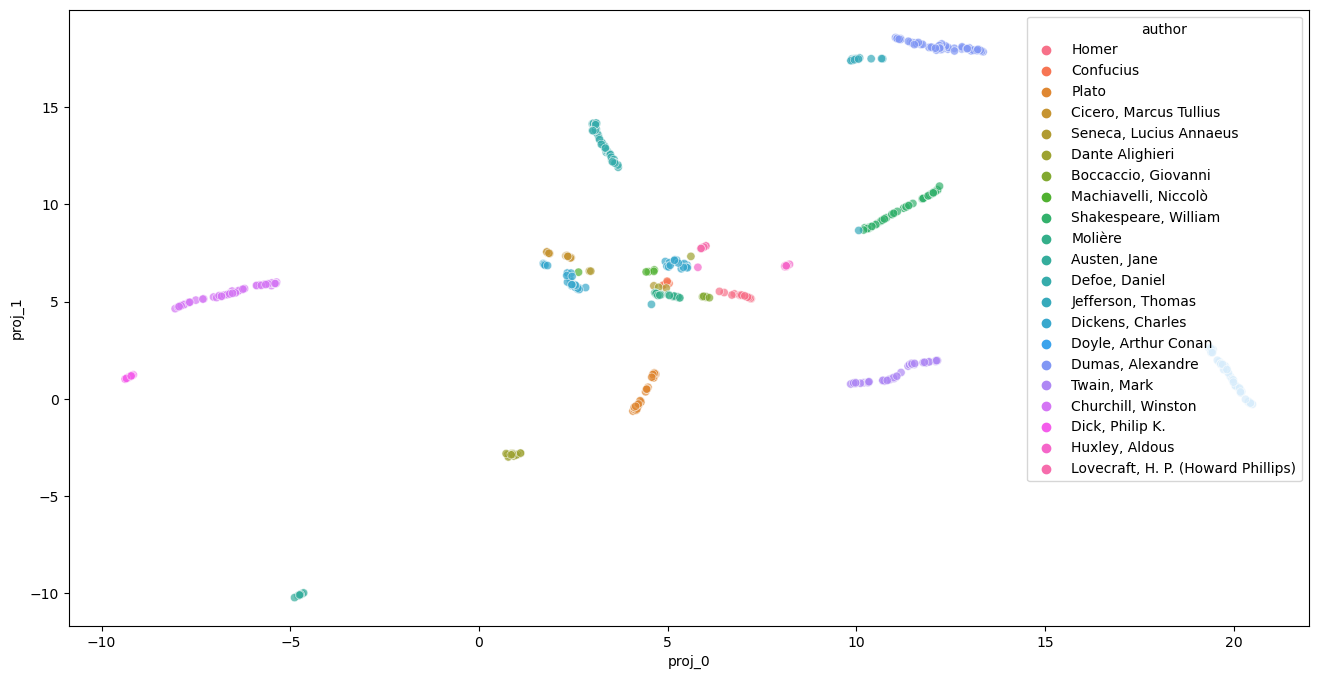

In [16]:
# # old code:
# sns.scatterplot(x=umap_projection[:,0], y=umap_projection[:,1], 
#                 hue = library_select.replace({'author': num_to_authors})['author'].astype('category'),
#                alpha = 0.7);

plt.figure(figsize = (16,8))
sns.scatterplot(data=library_select, x='proj_0', y='proj_1', 
                hue = 'author',
               alpha = 0.7);

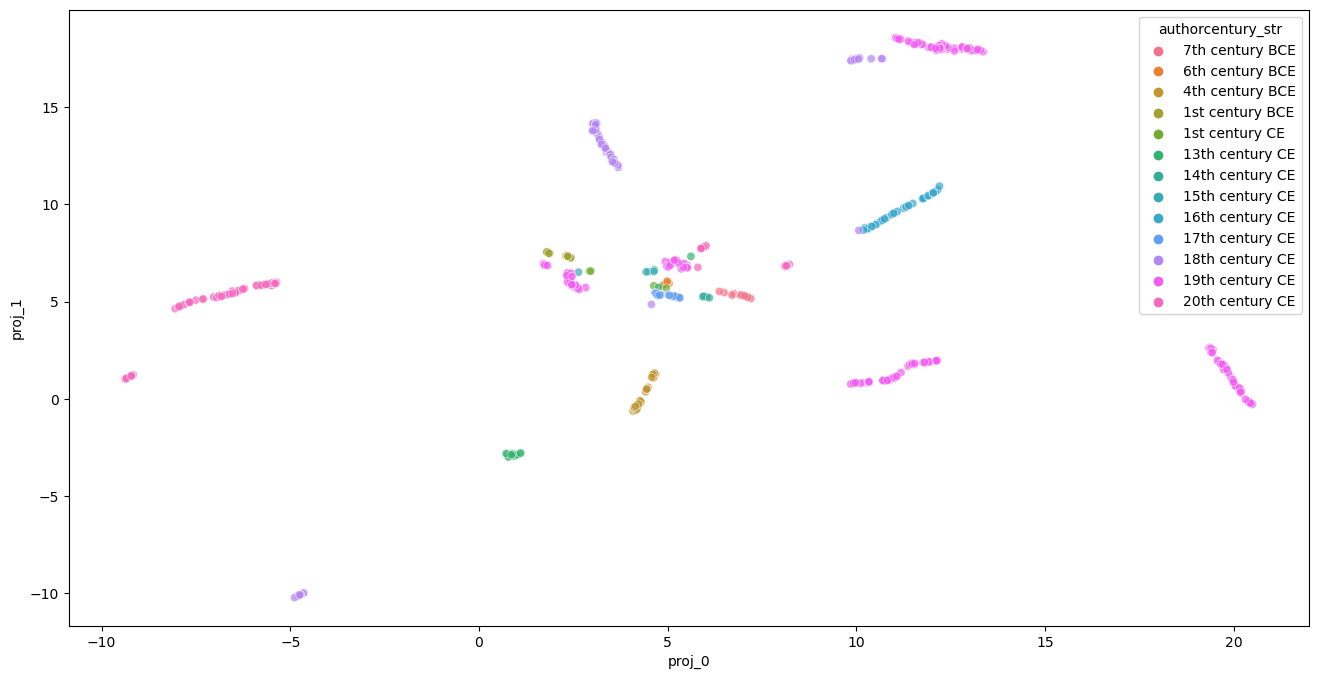

In [17]:
plt.figure(figsize = (16,8))
sns.scatterplot(data=library_select, x='proj_0', y='proj_1', 
                hue = library_select['authorcentury_str'],
               alpha = 0.7);

In [18]:
# make a copy -- personal note: important to use copy!! otherwise, it's just a view of the original dataframe 
# and that gives warnings in the following two parts
library_2d_dist = library_select[['author', 'proj_0', 'proj_1']].copy()

# calculate the mean point for each author
library_2d_dist[['proj_0_mean', 'proj_1_mean']] = library_2d_dist.groupby('author')[['proj_0', 'proj_1']].transform('mean')

# get the distance between each point and the mean for that author
library_2d_dist['dist_mean'] = np.sqrt((library_2d_dist['proj_0'] - library_2d_dist['proj_0_mean'])**2 + (library_2d_dist['proj_1'] - library_2d_dist['proj_1_mean'])**2)

In [19]:
library_2d_dist

,author,proj_0,proj_1,proj_0_mean,proj_1_mean,dist_mean
56951,Homer,7.209781,5.136944,6.936187,5.295058,0.315997
8076,Homer,6.767606,5.392134,6.936187,5.295058,0.194533
13293,Homer,6.904710,5.326296,6.936187,5.295058,0.044346
23961,Homer,7.075434,5.252836,6.936187,5.295058,0.145508
7160,Homer,7.188759,5.158536,6.936187,5.295058,0.287108
...,...,...,...,...,...,...
64643,"Lovecraft, H. P. (Howard Phillips)",5.903898,7.747753,5.935886,7.780312,0.045644
23804,"Lovecraft, H. P. (Howard Phillips)",6.011392,7.856031,5.935886,7.780312,0.106932
22880,"Lovecraft, H. P. (Howard Phillips)",5.957997,7.797246,5.935886,7.780312,0.027850
64994,"Lovecraft, H. P. (Howard Phillips)",5.878820,7.721108,5.935886,7.780312,0.082229


In [20]:
library_2d_dist['dist_mean'].describe()

count    527.000000
mean       0.819817
std        0.943572
min        0.001586
25%        0.262010
50%        0.738453
75%        1.173484
max       12.528560
Name: dist_mean, dtype: float64

In [21]:
dist2d_mean = library_2d_dist['dist_mean'].mean()

In [52]:
library_select['dist2d_mean'] = dist2d_mean

In [54]:
# saving for streamlit
library_select.to_pickle('../data/library_distances2d.pkl')

## Similarity using spatial distance in 100 dimension

Another way to look at the produced weights and which ones are similar

Calculating cosine similarity (using dim_0 to dim_99 cols) - for a first attempt, group it by author.

In [16]:
# idea use this to transpose and then see the dist from each book to this point?
library_select_grouped = library_select.drop(columns=['id','title','authorcentury_str','proj_0','proj_1']).groupby('author').mean()

KeyError: "['proj_0', 'proj_1'] not found in axis"

In [25]:
dists = spatial.distance.pdist(library_select_grouped.values, metric='euclidean') # metric='cosine'

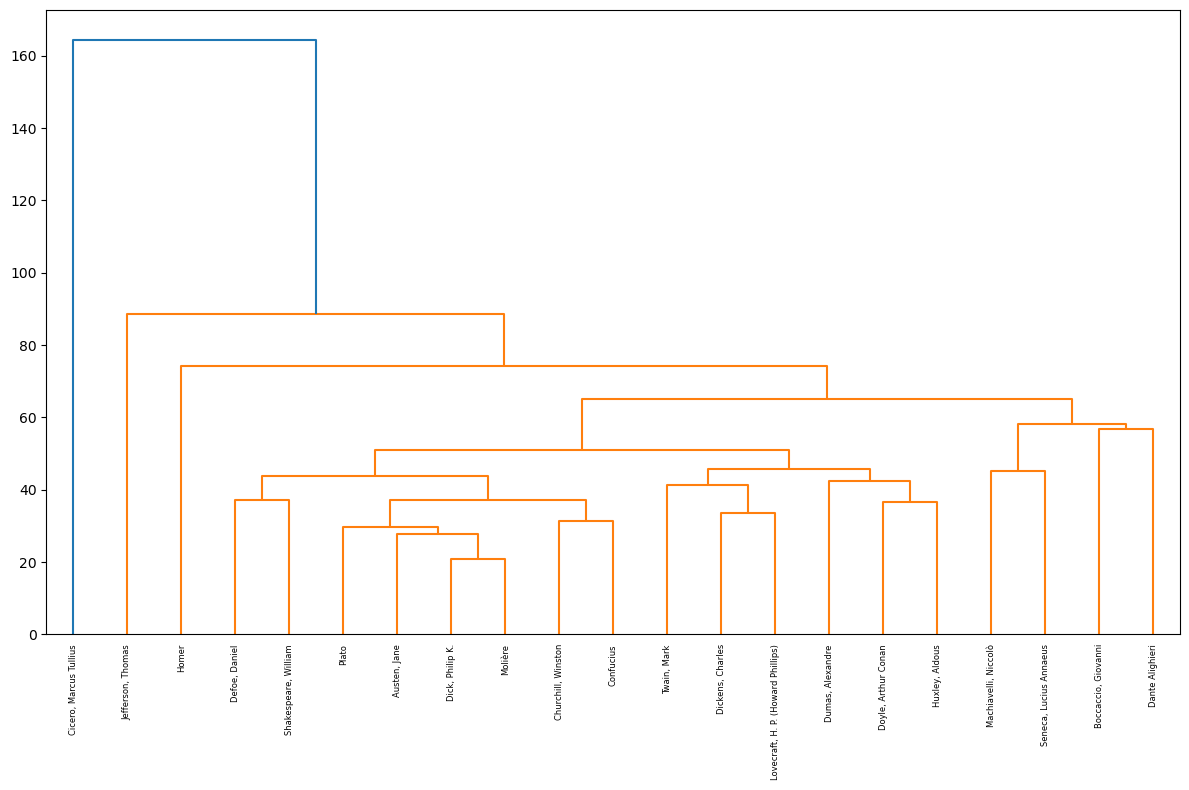

In [26]:
mergings = linkage(dists, method='complete')

plt.figure(figsize = (12,8))
dendrogram(mergings,
           labels = list(library_select_grouped.index),
           leaf_rotation = 90,
           leaf_font_size = 6);

plt.tight_layout()

In [ ]:
# before I realized to use this approach, I first concatenated all the texts in the pandas series which returns an extremely long string
# I then turn that string into a pandas series (the predict requires an iterable object)
# pipe_nn.predict(pd.Series(library_select.loc[library_select['author'] == 0]['book_content'].str.cat()))

## Introducing New Text

This part will ideally be in an app where any text can be uploaded

Here I will test it with two books I've written.

In [ ]:
# if the model was not run above, this is where we load the encoder and the umamp_mnist
# pipe_nn_encoder = load('../models/pipe_nn_encoder_01.joblib') 
# umap_mnist = load('../models/umap_mnist_01.joblib')

In [31]:
newtext = pd.DataFrame()

for book_num, book_name in enumerate(['Lambda', 'Deathway']):
        filepath = f'../data/{book_name} by Tomo Umer.txt'

        with open(filepath, encoding = 'utf-8') as fi:
                book = fi.read()
        
        tmp_text = pd.DataFrame({'id': f'TU{str(book_num).zfill(3)}',
                                 'title': [book_name],
                                 'author': 'Umer, Tomo',
                                 'authorcentury_str': '21st century CE',
                                 'book_content': [book]})

        newtext = pd.concat([newtext, tmp_text], ignore_index = True)

In [32]:
newtext

,id,title,author,authorcentury_str,book_content
0,TU000,Lambda,"Umer, Tomo",21st century CE,Lambda\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n...
1,TU001,Deathway,"Umer, Tomo",21st century CE,DeathwayIndex\nIntroduction\nMy second novel! ...


As a reminder (to myself), in order to convert the new texts, we only need predict and transform methods

In [33]:
# now using predict from the encoder to get the 100-dimensional projection of new text
nn_represent_newtext = pipe_nn_encoder.predict(newtext['book_content'])

# and its 2d representation using umap
umap_projection_newtext = umap_mnist.transform(nn_represent_newtext)

In [34]:
# and then just like with the authors, convert new texts into a dataframe
# convert the 100 dimensional vector of neuron weights into dataframe
newtxt_represent = pd.DataFrame(nn_represent_newtext, columns=[f'dim_{x}' for x in range(100)])

# and also the 2d representation
newtxt_proj = pd.DataFrame(umap_projection_newtext, columns=[f'proj_{x}' for x in range(2)])

# concatenate together with some info from the original df. at this point, for this notebook won't be needing the book texts anymore
# I'll create a new notebook for NN from a different package
newtext = pd.concat([
    newtext[['id','title','author','authorcentury_str']],
    newtxt_proj.set_index(newtext.index),
    newtxt_represent.set_index(newtext.index)],
    axis=1)

Then, use the median 0.549409 (or possibly mean 0.721832) value to get a circle around the new texts - to visually represent similar books.

In [35]:
circle_edges = newtext[['proj_0', 'proj_1']].copy()

In [36]:
circle_edges['x0'] = circle_edges['proj_0'] - dist2d_mean
circle_edges['x1'] = circle_edges['proj_0'] + dist2d_mean
circle_edges['y0'] = circle_edges['proj_1'] - dist2d_mean
circle_edges['y1'] = circle_edges['proj_1'] + dist2d_mean

In [37]:
circle_edges

,proj_0,proj_1,x0,x1,y0,y1
0,6.869560,4.503577,6.049742,7.689377,3.683759,5.323394
1,5.281713,7.188531,4.461895,6.101531,6.368713,8.008348


Finally, simply add the new text to the library.

In [38]:
library_newtext = pd.concat([library_select, newtext])

In [39]:
library_select.head()

,id,title,author,authorcentury_str,proj_0,proj_1,dim_0,dim_1,dim_2,dim_3,...,dim_90,dim_91,dim_92,dim_93,dim_94,dim_95,dim_96,dim_97,dim_98,dim_99
56951,PG6130,The Iliad,Homer,7th century BCE,7.209781,5.136944,31.972428,5.825817,7.852293,1.029979,...,18.477751,32.159493,13.639279,0.0,0.0,16.124452,15.047077,0.00000,0.0,0.0
8076,PG1727,The Odyssey: Rendered into English prose for t...,Homer,7th century BCE,6.767606,5.392134,13.369946,1.337962,3.519954,0.172030,...,5.607742,11.612362,1.599361,0.0,0.0,7.323183,4.742896,0.36624,0.0,0.0
13293,PG2199,The Iliad,Homer,7th century BCE,6.904710,5.326296,15.358421,3.172665,4.607730,0.000000,...,9.925390,16.308395,5.032056,0.0,0.0,9.510005,6.671427,0.00000,0.0,0.0
23961,PG3160,The Odyssey,Homer,7th century BCE,7.075434,5.252836,21.878607,2.897674,5.948186,2.086448,...,13.263615,21.716379,9.042165,0.0,0.0,13.184772,6.047783,0.00000,0.0,0.0
7160,PG16452,The Iliad of Homer: Translated into English Bl...,Homer,7th century BCE,7.188759,5.158536,40.097839,0.000000,10.014814,0.000000,...,25.754889,45.880332,10.021244,0.0,0.0,23.948121,21.173872,0.00000,0.0,0.0


In [40]:
fig = px.scatter(data_frame = library_newtext,
                 x='proj_0',
                 y='proj_1',
                 width=1200,
                 height=800,
                 color= 'author',
                 color_discrete_sequence=px.colors.qualitative.Alphabet, #Dark24
                 hover_data= ['title']
                 )

for i in range(circle_edges.shape[0]):
    fig.add_shape(type='circle',
        xref='x', yref='y',
        x0=circle_edges['x0'][i],
        y0=circle_edges['y0'][i],
        x1=circle_edges['x1'][i],
        y1=circle_edges['y1'][i],
        line_color='LightSeaGreen',
    )


fig.show()

In [42]:
fig = px.scatter(data_frame = library_newtext,
                 x='proj_0',
                 y='proj_1',
                 width=1200,
                 height=800,
                 color= 'authorcentury_str', #library_newtext['authorcentury'].astype('category'),
                 color_discrete_sequence=px.colors.qualitative.Alphabet, #Dark24
                 hover_data= ['title']
                 )

fig.show()

In [44]:
dists = spatial.distance.pdist(library_newtext.drop(columns=['id', 'title', 'author', 'authorcentury_str', 'proj_0', 'proj_1']).values,  metric='euclidean') #metric = 'cosine'

In [45]:
np.mean(dists)

61.401320729984675

note: to find out the dist between two authors, need to get the correct index for dist.

for i < j < m (where m = num of authors):

index = m * i + j - ((i + 2) * (i + 1)) // 2

dists[index]

For Lambda, cosine distance:

In [46]:
m = library_newtext.shape[0]
j = m-2

cos_dist = []
titles = []
authors = []

for i in range(j):
    titles.append(library_newtext['title'].iloc[i])
    authors.append(library_newtext['author'].iloc[i])
    cos_dist.append(dists[m * i + j - ((i + 2) * (i + 1)) // 2])

In [47]:
pd.concat([pd.DataFrame({'title':titles}),
           pd.DataFrame({'author':authors}),
           pd.DataFrame({'Lambda':cos_dist})],
           axis=1).sort_values(by='Lambda', ascending=True).head(10)

,title,author,Lambda
464,An essay on the American contribution and the ...,"Churchill, Winston",31.093656
431,Mark Twain's Letters — Volume 1 (1853-1866),"Twain, Mark",31.470893
508,Crome Yellow,"Huxley, Aldous",31.694713
12,The Adventures of Ulysses the Wanderer,Homer,32.494590
1,The Odyssey: Rendered into English prose for t...,Homer,32.933620
446,My African Journey,"Churchill, Winston",33.109292
451,Liberalism and the Social Problem,"Churchill, Winston",33.110366
2,The Iliad,Homer,33.311928
450,London to Ladysmith via Pretoria,"Churchill, Winston",33.934482
272,Some Christmas Stories,"Dickens, Charles",34.068379


For Deathway, cosine distance:

In [48]:
m = library_newtext.shape[0]
j = m-1

cos_dist = []
titles = []
authors = []

for i in range(j):
    titles.append(library_newtext['title'].iloc[i])
    authors.append(library_newtext['author'].iloc[i])
    cos_dist.append(dists[m * i + j - ((i + 2) * (i + 1)) // 2])

In [49]:
# Lambda is of course the most similar ... if wanted, simply do a .drop(538) on all 3 dataframes
pd.concat([pd.DataFrame({'title':titles}),
           pd.DataFrame({'author':authors}),
           pd.DataFrame({'Deathway':cos_dist})],
           axis=1).sort_values(by='Deathway', ascending=True).head(20)

,title,author,Deathway
282,The Haunted Man and the Ghost's Bargain,"Dickens, Charles",15.289262
274,The Chimes: A Goblin Story of Some Bells That ...,"Dickens, Charles",15.455539
267,Hunted Down: The Detective Stories of Charles ...,"Dickens, Charles",15.468699
288,The Perils of Certain English Prisoners,"Dickens, Charles",15.512753
275,The Cricket on the Hearth: A Fairy Tale of Home,"Dickens, Charles",15.658214
291,The Battle of Life,"Dickens, Charles",15.736545
290,A Message from the Sea,"Dickens, Charles",15.996803
368,The Corsican Brothers,"Dumas, Alexandre",16.154628
273,To Be Read at Dusk,"Dickens, Charles",16.298370
278,Holiday Romance,"Dickens, Charles",16.376004
